<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/Import_DXF_for_OASIS_Conversion_Using_GDSTK_SQUID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [1]:
# @title Install libraries
%pip -q install "gdstk>=0.9.61" "ezdxf>=1.4.2" "matplotlib>=3.9"

import os, itertools
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gdstk
import ezdxf
from ezdxf import path as ezpath
from ezdxf.document import Drawing  # <-- correct type for ezdxf.readfile()

# High-resolution previews
mpl.rcParams["figure.dpi"] = 1200
mpl.rcParams["savefig.dpi"] = 1200

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 39.8 MB/s eta 0:00:00


In [2]:
# @title Upload/Select DXF into /content/
from google.colab import files

DXF_BASENAME = "80nm_JJ_Qubit.dxf"  # <-- change to your filename after uploading
DXF_PATH = Path("/content") / DXF_BASENAME

if not DXF_PATH.exists():
    sample = Path("/mnt/data/80nm_JJ_Qubit.dxf")
    if sample.exists() and DXF_BASENAME == "80nm_JJ_Qubit.dxf":
        DXF_PATH.write_bytes(sample.read_bytes())
        print(f"Copied sample to: {DXF_PATH}")
    else:
        print("Please upload a .dxf now; it will be saved into /content/")
        uploaded = files.upload()
        if DXF_BASENAME not in uploaded:
            DXF_BASENAME = next(iter(uploaded.keys()))
            DXF_PATH = Path("/content") / DXF_BASENAME

assert DXF_PATH.exists(), f"DXF not found: {DXF_PATH}"
print("Using DXF:", DXF_PATH)


Using DXF: /content/80nm_JJ_Qubit.dxf


In [3]:
# @title Helpers: units, layer mapping, path flattening

# $INSUNITS → meters per drawing unit (AutoCAD system variable)
INSUNITS_TO_METERS = {
    0: 1.0, 1: 0.0254, 2: 0.3048, 3: 1609.344, 4: 1e-3, 5: 1e-2, 6: 1.0, 7: 1e3,
    8: 25.4e-9, 9: 25.4e-6, 10: 0.9144, 11: 1e-10, 12: 1e-9, 13: 1e-6, 14: 1e-1,
    15: 1e1, 16: 1e2, 17: 1e9, 18: 1.495978707e11, 19: 9.4607304725808e15,
    20: 3.085677581e16, 21: 0.3048006096012192, 22: 0.0254000508,
    23: 0.9144018288036576, 24: 1609.3472186944373,
}

def insunits_to_um(ins: int, unitless_default_um_per_unit: float = 1.0) -> float:
    """Micrometers per DXF drawing unit."""
    if int(ins or 0) == 0:
        return float(unitless_default_um_per_unit)  # unitless → assume 1 unit = 1 µm
    return INSUNITS_TO_METERS.get(int(ins), 1.0) * 1e6

def build_layer_map(doc: Drawing) -> Dict[str, Tuple[int, int]]:
    """DXF layer names → (OASIS layer, datatype)."""
    names = [lay.dxf.name for lay in doc.layers]
    return {name: (i + 1, 0) for i, name in enumerate(sorted(set(names)))}

def entity_to_paths(e) -> Iterable[ezpath.Path]:
    """Yield ezdxf Path objects for an entity; expand HATCH."""
    if e.dxftype() == "HATCH":
        yield from ezpath.from_hatch(e)
    else:
        try:
            yield ezpath.make_path(e)  # LINE/CIRCLE/ARC/ELLIPSE/SPLINE/LWPOLYLINE/POLYLINE...
        except TypeError:
            return

def subpaths(p: ezpath.Path) -> Iterable[ezpath.Path]:
    """Split multi-paths into single closed/open subpaths."""
    if getattr(p, "has_sub_paths", False):
        yield from p.sub_paths()
    else:
        yield p

$INSUNITS=0 → 1 µm per drawing unit
Layers mapped: 5 shown: [('0', (1, 0)), ('BOTTOM_FOOTPRINT', (2, 0)), ('Defpoints', (3, 0)), ('L0D0_0', (4, 0)), ('PILLARS', (5, 0))]
Wrote OASIS: /content/out_dxf2oas/80nm_JJ_Qubit.oas


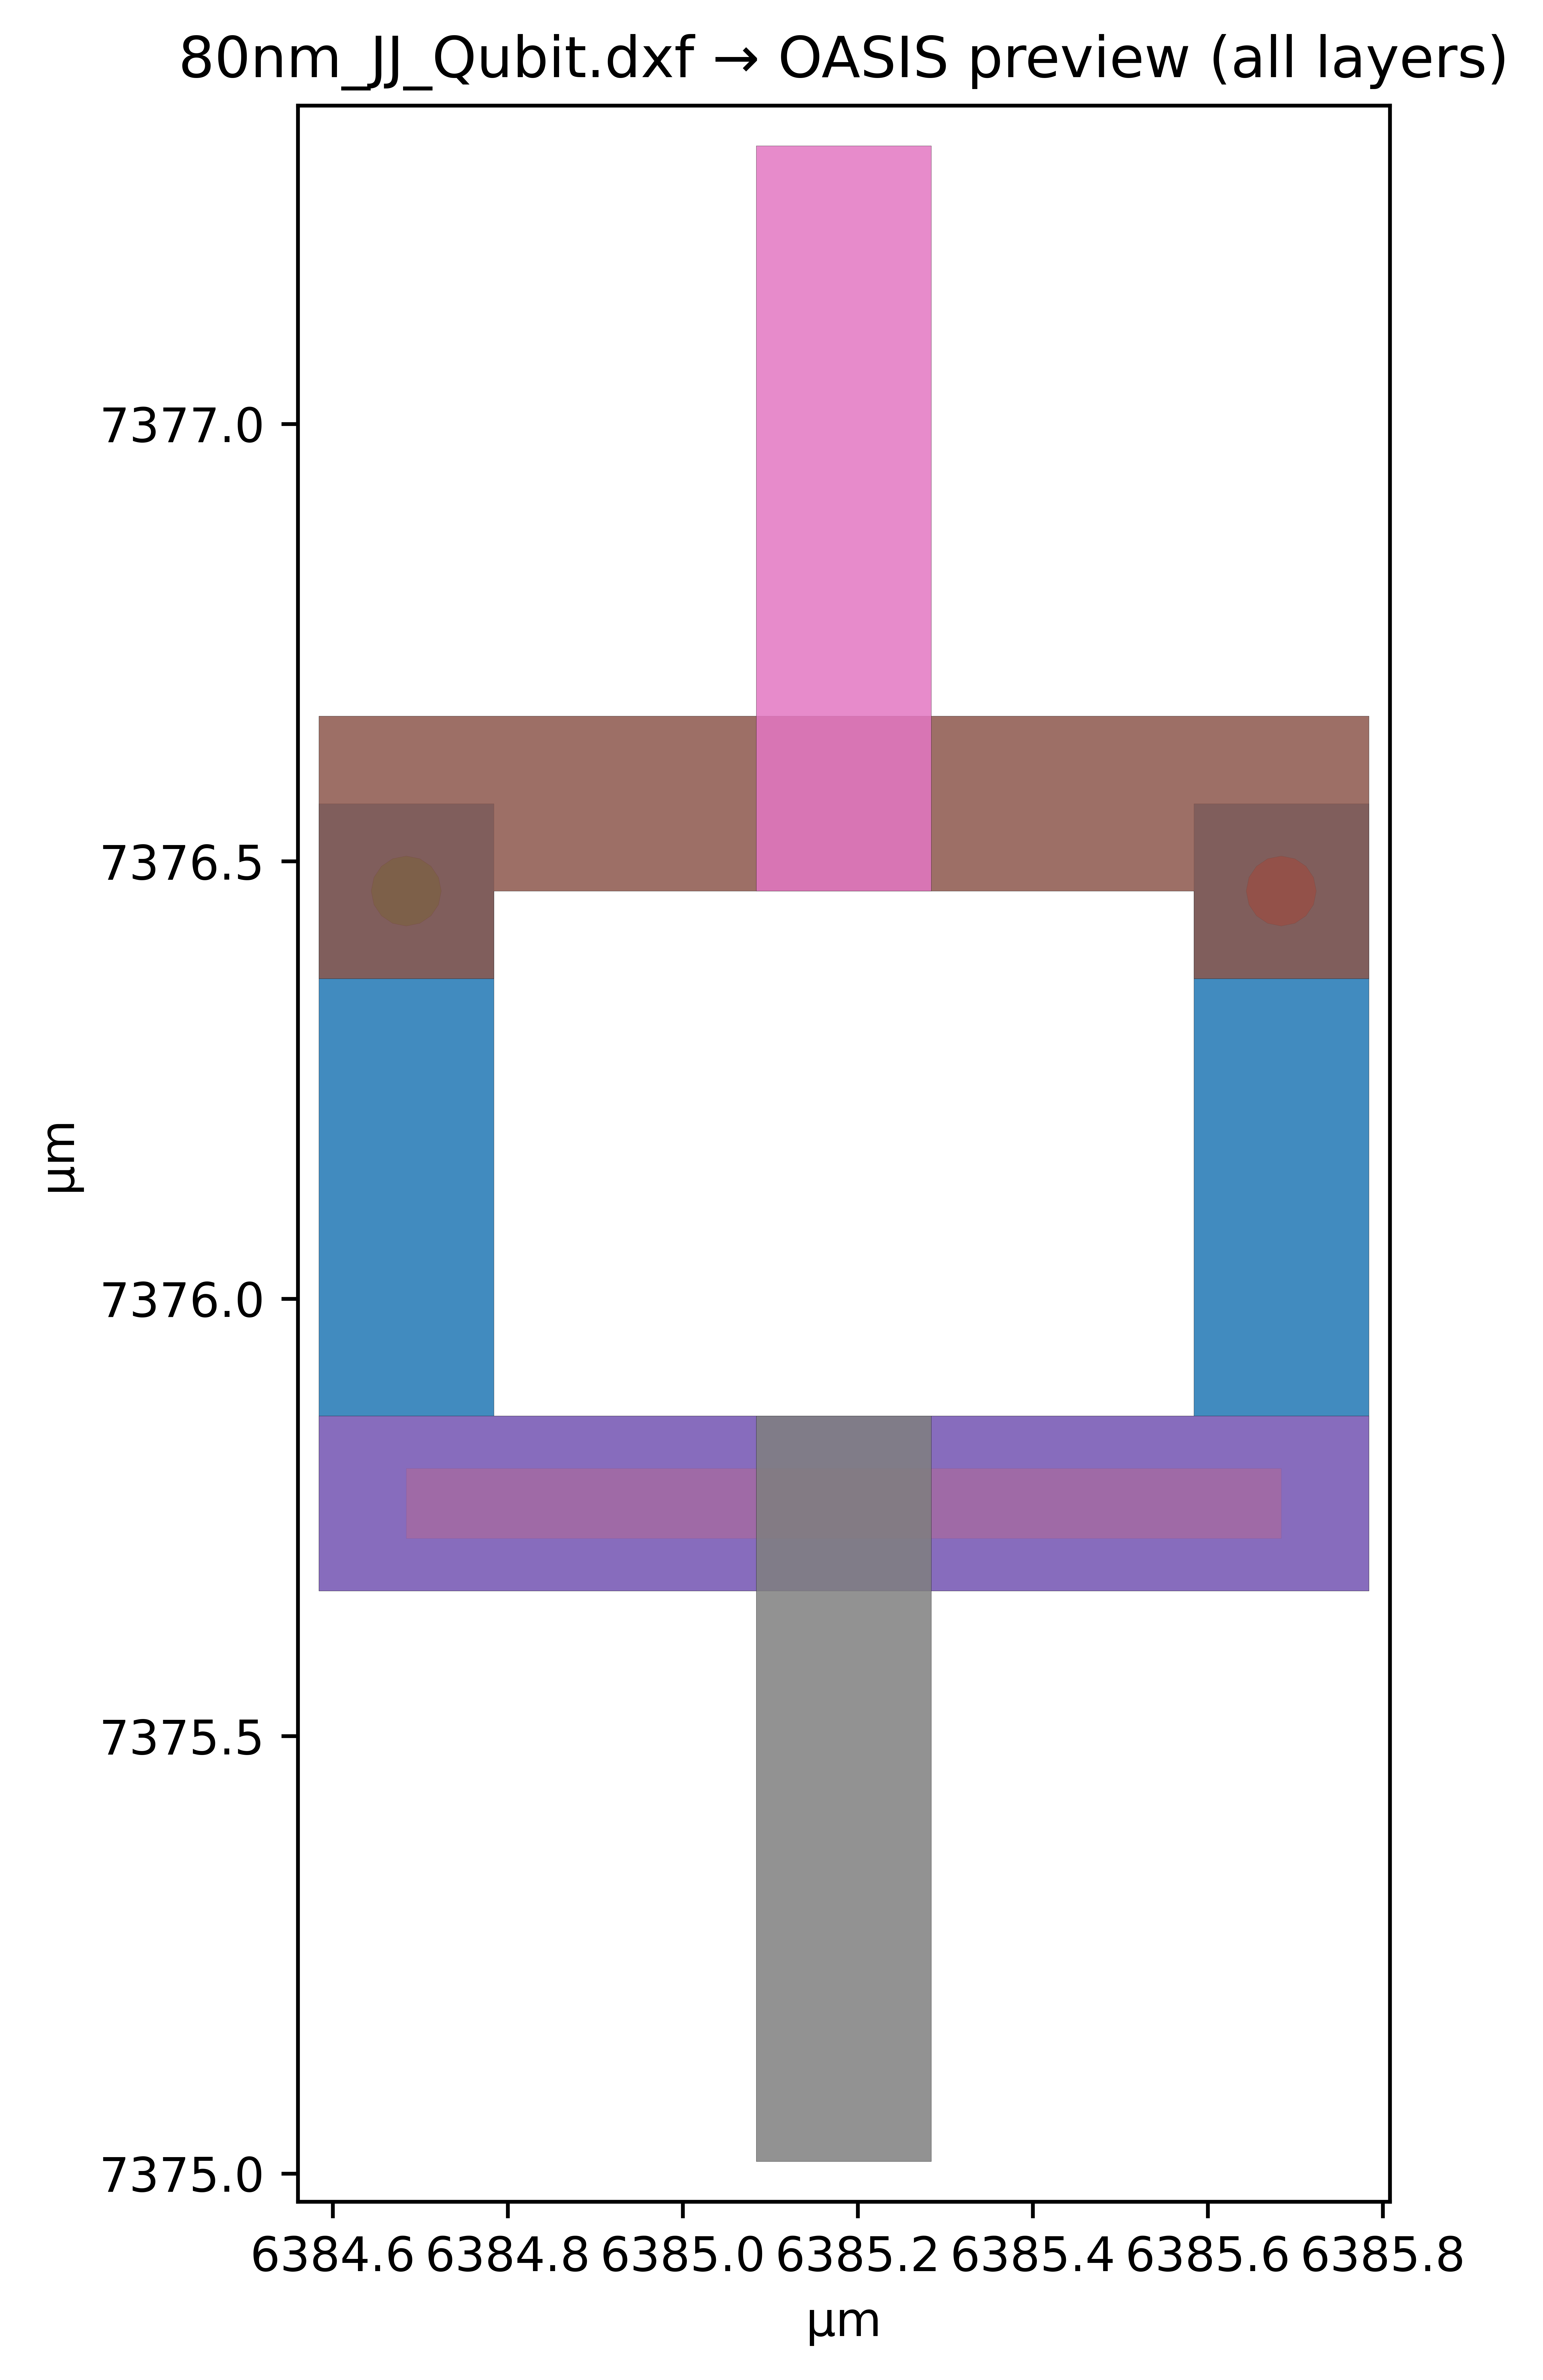

Preview PNG: /content/out_dxf2oas/80nm_JJ_Qubit_preview_all_layers.png


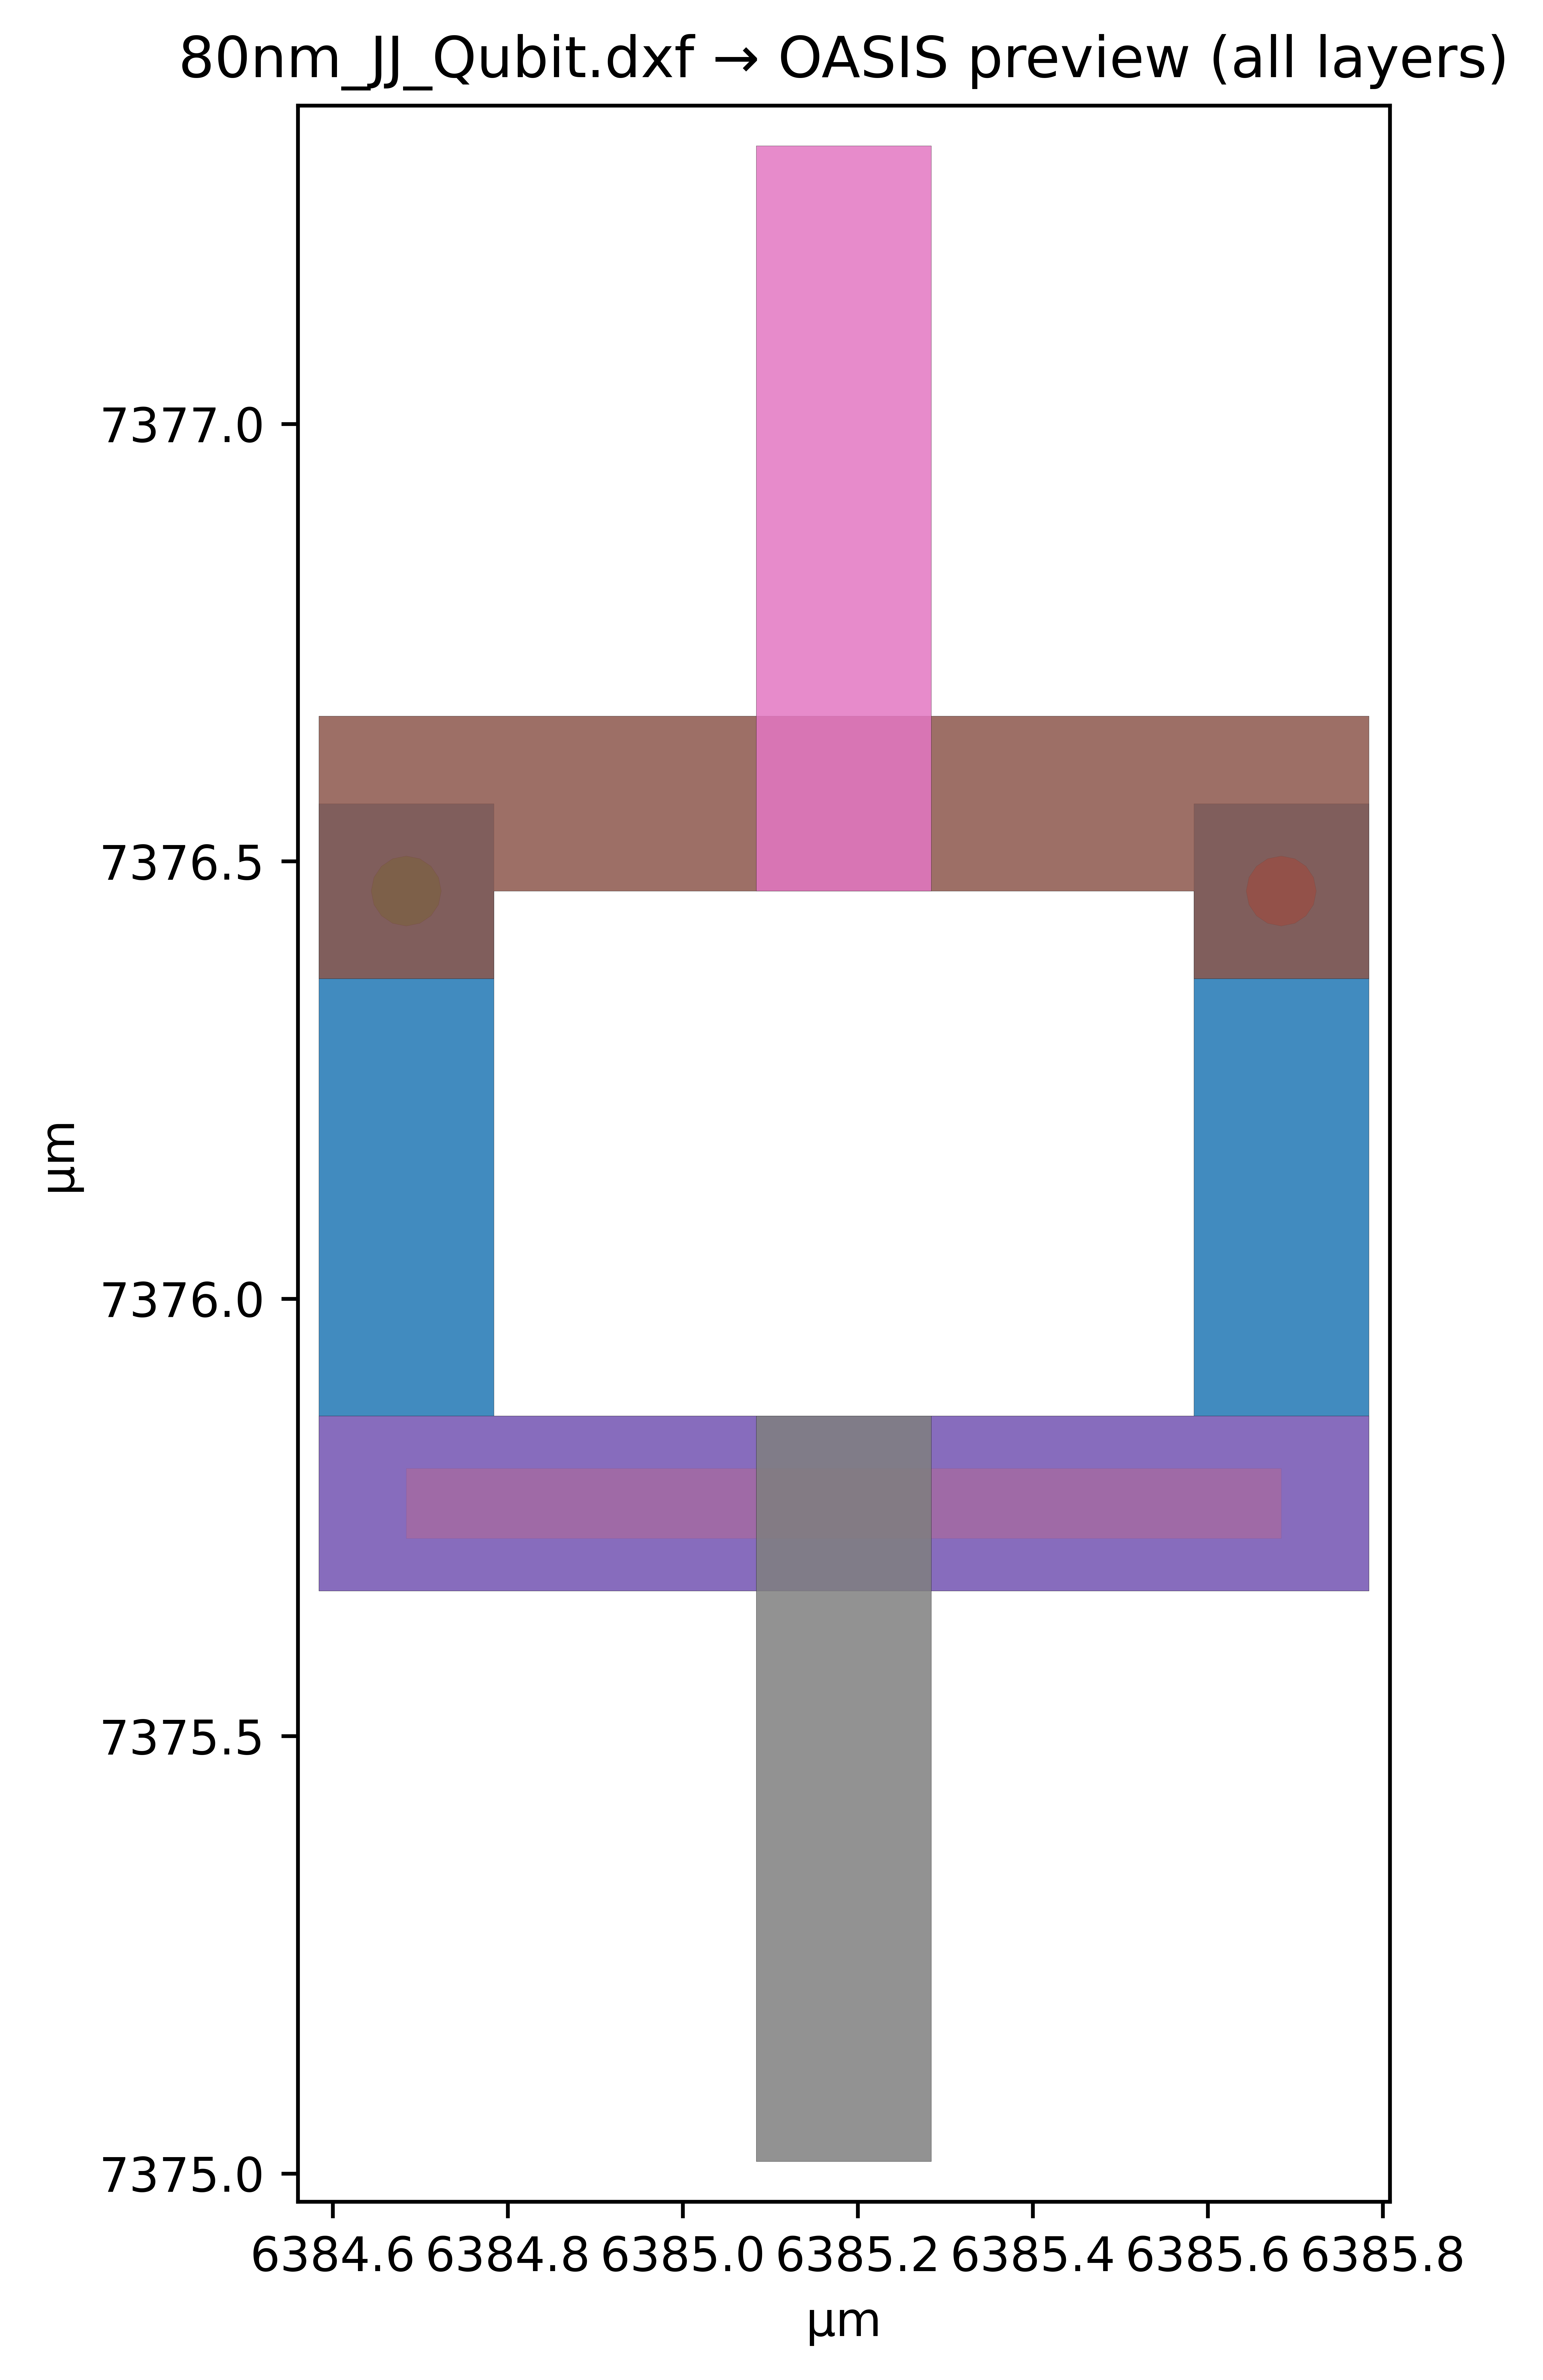

In [4]:
# @title DXF → OASIS + 1200-dpi preview
OUT_ROOT = Path("/content/out_dxf2oas")
OUT_ROOT.mkdir(parents=True, exist_ok=True)
OAS_PATH = OUT_ROOT / (DXF_PATH.stem + ".oas")
PREVIEW_PNG = OUT_ROOT / (DXF_PATH.stem + "_preview_all_layers.png")

# User knobs
UNITLESS_UM_PER_UNIT = 1.0
FLATTEN_TOL_UM = 0.1
DEFAULT_PATH_WIDTH_UM = 1.0

# 1) Read DXF safely; fall back to recover if necessary
try:
    doc = ezdxf.readfile(str(DXF_PATH))
except ezdxf.DXFStructureError:
    from ezdxf import recover
    doc, auditor = recover.readfile(str(DXF_PATH))
    if auditor.has_errors:
        print("Warning: DXF had recoverable errors.")

msp = doc.modelspace()
ins = int(doc.header.get("$INSUNITS", 0))
um_per_unit = insunits_to_um(ins, UNITLESS_UM_PER_UNIT)
print(f"$INSUNITS={ins} → {um_per_unit:.6g} µm per drawing unit")

# 2) Build a DXF-layer → (layer, datatype) map
layer_map: Dict[str, Tuple[int, int]] = build_layer_map(doc)
print("Layers mapped:", min(5, len(layer_map)), "shown:", list(itertools.islice(layer_map.items(), 0, 5)))

# 3) Create gdstk library (user-unit = 1 µm)
lib = gdstk.Library(name="DXF_CONVERSION", unit=1e-6, precision=1e-9)
top = lib.new_cell("TOP_FROM_DXF")

# 4) Iterate modelspace and expand inserts
def iter_graphics(layout):
    for e in layout:
        if e.dxftype() == "INSERT":
            try:
                for ve in e.virtual_entities():
                    yield ve
            except Exception:
                continue
        else:
            yield e

tol_units = FLATTEN_TOL_UM / um_per_unit

def add_path(points_um: np.ndarray, layer: int, dtype: int):
    p = gdstk.FlexPath(points_um, DEFAULT_PATH_WIDTH_UM, layer=layer, datatype=dtype)
    top.add(p)

def add_polygon(points_um: np.ndarray, layer: int, dtype: int):
    if len(points_um) >= 3:
        top.add(gdstk.Polygon(points_um, layer=layer, datatype=dtype))

supported = {"LINE","LWPOLYLINE","POLYLINE","CIRCLE","ARC","ELLIPSE","SPLINE","HATCH"}
skipped = {}

for e in iter_graphics(msp):
    if e.dxftype() not in supported:
        skipped[e.dxftype()] = skipped.get(e.dxftype(), 0) + 1
        continue
    for p in entity_to_paths(e):
        for sp in subpaths(p):
            verts = np.array(list(sp.flattening(distance=tol_units)), dtype=float)
            if verts.size == 0:
                continue
            verts_um = verts[:, :2] * um_per_unit
            lay, dt = layer_map.get(getattr(e.dxf, "layer", "0"), (1, 0))
            # closed → polygon; open → path
            is_closed = bool(getattr(sp, "is_closed", False))
            if not is_closed and np.allclose(verts_um[0], verts_um[-1], atol=1e-12):
                is_closed = True
            (add_polygon if is_closed else add_path)(verts_um, lay, dt)

# 5) Write OASIS
lib.write_oas(str(OAS_PATH))
print("Wrote OASIS:", OAS_PATH)

# 6) 1200-dpi preview (flatten a deep copy; include paths) — with inline plotting
from IPython.display import display, Image
from IPython import get_ipython
import numpy as np
import matplotlib.pyplot as plt

# Ensure inline backend (safe in Colab/Jupyter)
get_ipython().run_line_magic("matplotlib", "inline")

# Copy with a name, then flatten to materialize references
draw = top.copy(name=f"{top.name}_PREVIEW", deep_copy=True)
draw.flatten(apply_repetitions=True)  # include referenced geometry

# Normalize polygons: gdstk may return ndarray or gdstk.Polygon; convert both to (N,2) arrays
raw_polys = draw.get_polygons(apply_repetitions=False, include_paths=True)
poly_arrays = []
for p in raw_polys:
    arr = p if isinstance(p, np.ndarray) else np.asarray(p.points, dtype=float)
    if arr is not None and arr.shape[0] >= 3:
        poly_arrays.append(arr)

if poly_arrays:
    xs = np.concatenate([a[:, 0] for a in poly_arrays])
    ys = np.concatenate([a[:, 1] for a in poly_arrays])

    # NumPy 2.x: use function-form ptp, not xs.ptp() / ys.ptp()
    xpad = 0.02 * max(np.ptp(xs), 1e-9)
    ypad = 0.02 * max(np.ptp(ys), 1e-9)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(xs.min() - xpad, xs.max() + xpad)
    ax.set_ylim(ys.min() - ypad, ys.max() + ypad)
    ax.set_xlabel("µm"); ax.set_ylabel("µm")
    ax.set_title(f"{DXF_PATH.name} → OASIS preview (all layers)")

    for a in poly_arrays:
        ax.fill(a[:, 0], a[:, 1], alpha=0.85, edgecolor="black", linewidth=0.05)

    # Show inline in the notebook
    plt.show()  # <-- this actually renders the figure inline

    # Also save a 1200-dpi PNG for archival or download
    fig.savefig(PREVIEW_PNG, bbox_inches="tight", dpi=1200)
    print("Preview PNG:", PREVIEW_PNG)

    # And display the saved PNG explicitly (extra assurance)
    display(Image(filename=str(PREVIEW_PNG)))
else:
    print("No polygons to preview.")

In [5]:
# @title Download OASIS / preview
from google.colab import files
files.download(str(OAS_PATH))
# files.download(str(PREVIEW_PNG))  # uncomment to also download the PNG

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>